<a href="https://colab.research.google.com/github/Jayaprakash1618/speech-emotion-recognition/blob/main/speech_emotion_recognition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install librosa==0.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.7 MB/s eta 0:00:00
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201377 sha256=94a62de89351590ec55157ecbe16259afed9897007d7e417e8532bedbe49526e
  Stored in directory: /root/.cache/pip/wheels/bf/b7/85/2f8044306ccec014930aea23ad4852fca9e2584e21c6972bc6
Successfully built librosa
  Attempting uninstall: librosa
    Found existing installation: librosa 0.10.0.post2
    Uninstalling librosa-0.10.0.post2:
      Successfully uninstalled librosa-0.10.0.post2


In [ ]:
# IMPORT NECESSARY LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.regularizers import l2
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import classification_report


In [ ]:
x, sr = librosa.load('/content/drive/MyDrive/colab data sets/Google_colab/Audio_files/Actor_01/03-01-01-01-01-01-01.wav')

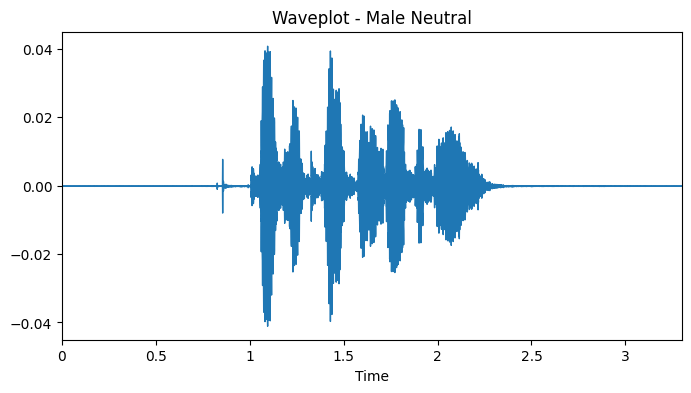

In [ ]:
# DISPLAY WAVEPLOT
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x,sr=sr)
plt.title('Waveplot - Male Neutral')
plt.savefig('Waveplot_MaleNeutral.png')

TypeError: ignored

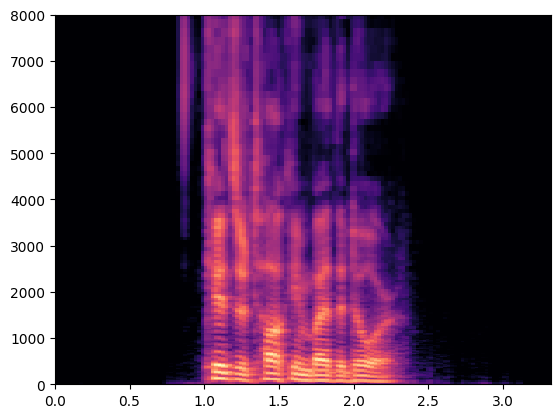

In [ ]:
# CREATE LOG MEL SPECTROGRAM
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.savefig('MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB');

In [ ]:
actor_folders = '/content/drive/MyDrive/colab data sets/Google_colab/Audio_files'
print(os.listdir(actor_folders))
emotion = []
gender = []
actor = []
file_path = []
for i in os.listdir(actor_folders):
    print("i",i)
    filename = os.listdir(os.path.join(actor_folders,i)) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        print(f)
        part = f.split('.')[0].split('-')
        print(part)
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append( i + '/' + f)
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)


['Actor_08', 'Actor_03', 'Actor_05', 'Actor_07', 'Actor_01', 'Actor_04', 'Actor_06', 'Actor_02', 'Actor_09', 'Actor_10', 'Actor_14', 'Actor_11', 'Actor_18', 'Actor_12', 'Actor_17', 'Actor_16', 'Actor_13', 'Actor_15', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_24', 'Actor_23', 'Actor_22']
i Actor_08
03-01-08-02-02-02-08.wav
['03', '01', '08', '02', '02', '02', '08']
03-01-01-01-02-02-08.wav
['03', '01', '01', '01', '02', '02', '08']
03-01-01-01-01-01-08.wav
['03', '01', '01', '01', '01', '01', '08']
03-01-02-01-02-02-08.wav
['03', '01', '02', '01', '02', '02', '08']
03-01-01-01-01-02-08.wav
['03', '01', '01', '01', '01', '02', '08']
03-01-04-01-02-02-08.wav
['03', '01', '04', '01', '02', '02', '08']
03-01-02-01-01-02-08.wav
['03', '01', '02', '01', '01', '02', '08']
03-01-06-01-01-02-08.wav
['03', '01', '06', '01', '01', '02', '08']
03-01-06-02-02-02-08.wav
['03', '01', '06', '02', '02', '02', '08']
03-01-07-01-02-02-08.wav
['03', '01', '07', '01', '02', '02', '08']
03-01-07-01-02-01-08

In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING
df = pd.DataFrame(columns=['mel_spectrogram'])
counter=0
# print(audio_df.path)
# print('########')
os.path.exists('/content/drive/MyDrive/colab data sets/Google_colab/Audio_files/Actor_16/03-01-02-01-02-01-16.wav') # Here we are just checking if the particular file is present is not.
for index,path in enumerate(audio_df.path):
    # print(path)
    X, sample_rate = librosa.load('/content/drive/MyDrive/colab data sets/Google_colab/Audio_files/'+path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)

    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)


    df.loc[counter] = [log_spectrogram]
    counter=counter+1
print(len(df))
df.head()

1068


,mel_spectrogram
0,"[-62.584003, -62.54762, -62.611095, -62.884094..."
1,"[-74.00031, -74.01498, -73.94064, -70.66498, -..."
2,"[-75.46676, -75.21872, -74.7257, -74.91033, -7..."
3,"[-78.44496, -77.814766, -77.845665, -78.6133, ..."
4,"[-74.654915, -74.61254, -73.87386, -73.66142, ..."


In [ ]:
# Taken from the git hub " -Initial_CNN_Model.ipynb "

df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)

In [ ]:
df_combined.drop(columns='path',inplace=True)

In [ ]:
df_combined.head()

,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,female,surprise,8,-62.584003,-62.547619,-62.611095,-62.884094,-62.866592,-62.695396,-62.629520,...,-62.861233,-62.619164,-62.497837,-62.598015,-62.526363,-62.565681,-62.593910,-62.651299,-63.144375,-63.161995
1,female,neutral,8,-74.000313,-74.014977,-73.940643,-70.664978,-69.550240,-71.609932,-73.193565,...,-74.469284,-74.468613,-74.556992,-74.692635,-74.941559,-74.582466,-74.709152,-74.643814,-74.439575,-74.396431
2,female,neutral,8,-75.466759,-75.218719,-74.725700,-74.910332,-74.844421,-75.036774,-75.190117,...,-75.228035,-76.189438,-76.066322,-75.761436,-75.026894,-74.849289,-75.180611,-75.474380,-75.293938,-74.694916
3,female,calm,8,-78.444962,-77.814766,-77.845665,-78.613297,-78.417473,-78.441856,-78.548996,...,-77.953224,-79.150261,-79.865036,-78.893867,-79.515121,-79.398392,-79.956375,0.000000,0.000000,0.000000
4,female,neutral,8,-74.654915,-74.612541,-73.873863,-73.661423,-74.257240,-74.246284,-74.022942,...,-73.997803,-74.182297,-74.331169,-74.416061,-74.430817,-74.351524,-74.923500,-74.177170,-74.371117,-74.561127


In [ ]:
train,test = train_test_split(df_combined, test_size=0.2, random_state=0, stratify=df_combined[['emotion','gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])

In [ ]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [ ]:
# BASE Model

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.04672897196261682

In [ ]:
# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Conv1D(128, kernel_size=(10),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 64)           704       
                                                                 
 conv1d_1 (Conv1D)           (None, 241, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 128)           163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 128)           0         
 1D)                                                    

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Conv1D(128, kernel_size=(20),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = keras.optimizers.Adam(lr=0.0001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 240, 64)           1344      
                                                                 
 conv1d_4 (Conv1D)           (None, 221, 128)          163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 27, 128)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 27, 128)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 128)            327808    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 128)           0         
 1D)                                                  